## Importing Required Libraries

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, BatchNormalization,Input, Conv2DTranspose, concatenate
from tensorflow.keras.utils import plot_model
import numpy as np
from tensorflow.keras import Model
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt

## Downloading Dataset Directly from Kaggle

In [2]:
# Dont forget to upload your kaggle.json before running this cell
!pip install kaggle
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!kaggle datasets download -d dansbecker/cityscapes-image-pairs

 96% 193M/202M [00:01<00:00, 190MB/s]
100% 202M/202M [00:01<00:00, 174MB/s]


## Loading Dataset

In [4]:
from zipfile import ZipFile
DT="/content/cityscapes-image-pairs.zip"
with ZipFile(DT, 'r') as p:
  p.extractall()

In [6]:
path = '/content/cityscapes_data/train'
image_paths=[]
for i in range (2):
  for filename in sorted(os.listdir(path)):
    
    image_path = os.path.join(path, filename)
    image_paths.append(image_path)

(256, 512, 3)
5950


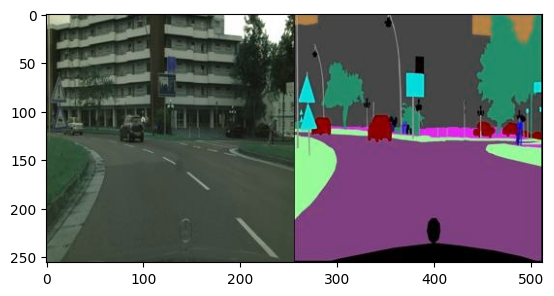

In [7]:
img0 = cv2.imread(image_paths[0])
plt.imshow(img0)
print(np.shape(img0))
print(len(image_paths))


# Preparing the Dataset for Model Training

In [8]:
#Spliting image into rel image and its mask
def split_image_and_mask(image_with_mask):
    # Split the image into real image and mask
    real_image = image_with_mask[:, :image_with_mask.shape[1] // 2, :]
    mask = image_with_mask[:, image_with_mask.shape[1] // 2:, :]

    return real_image, mask

In [9]:
def create_dataset(directory_path,n):
    real_images = []
    masks = []
    
    # Get the list of image files in the directory
    image_files = sorted(os.listdir(directory_path))
    image_files=image_files[:n]

    for file in image_files:
        # Read the image
        image_path = os.path.join(directory_path, file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Split the image into real image and mask
        real_image, mask = split_image_and_mask(image)
        real_image=cv2.resize(real_image,[128,128])
        mask=cv2.resize(mask,[128,128])

        # Preprocess or normalize the images as needed
        real_image =real_image/255.0
        mask      = mask/255.0    

        real_images.append(real_image)
        masks.append(mask)

    # Convert the lists to numpy arrays
    real_images = np.array(real_images)
    masks = np.array(masks)

    return real_images, masks

In [16]:
ds = tf.data.Dataset.from_tensor_slices(create_dataset(path,n=3000))

In [17]:
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Model Building

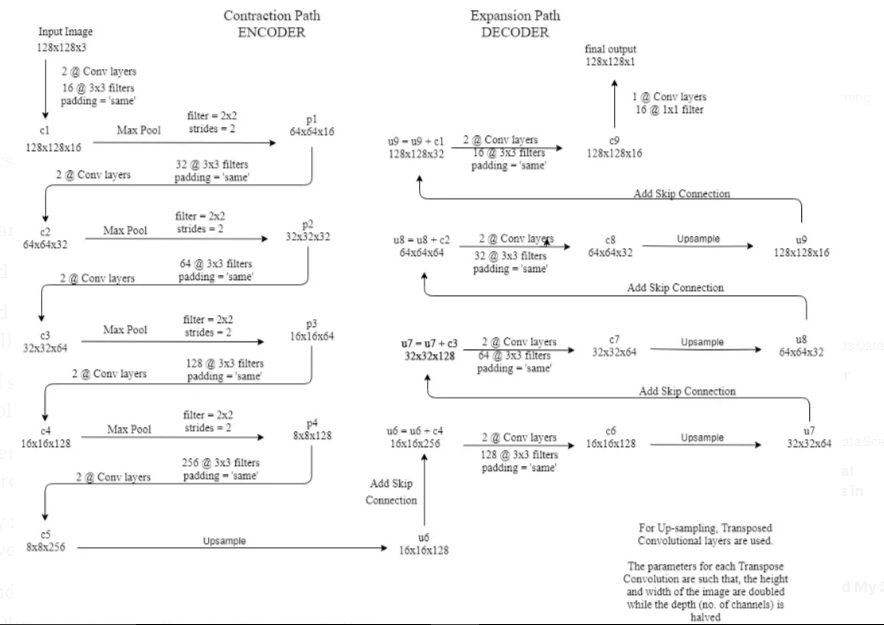

In [12]:
def conv_block(input, filter_num, batchnorm=True):
  c1=Conv2D(filter_num, 3, padding='same',
                  kernel_initializer='he_normal')(input)
  c2=Conv2D(filter_num, 3,padding='same',
                  kernel_initializer='he_normal')(c1)
  final_layer=tf.keras.layers.Dropout(0.1)(c2)
  return final_layer


In [13]:
def unet(input, num_classes, batch_norm=True):
    input = Input(shape=input)

    # Encoding Block
    c1 = conv_block(input, 16, batch_norm)
    m1 = MaxPool2D()(c1)

    c2 = conv_block(m1, 32, batch_norm)
    m2 = MaxPool2D()(c2)

    c3 = conv_block(m2, 64, batch_norm)
    m3 = MaxPool2D()(c3)

    c4 = conv_block(m3, 128, batch_norm)
    m4 = MaxPool2D()(c4)

    c5 = conv_block(m4, 256, batch_norm)

    ct1 = Conv2DTranspose(128, 3, strides=(2, 2), padding='same')(c5)
    cc1 = concatenate([ct1, c4])
    cv1 = conv_block(cc1, 128, batch_norm)

    ct2 = Conv2DTranspose(64, 3, strides=(2, 2), padding='same')(cv1)
    cc2 = concatenate([ct2, c3])
    cv2 = conv_block(cc2, 64, batch_norm)

    ct3 = Conv2DTranspose(32, 3, strides=(2, 2), padding='same')(cv2)
    cc3 = concatenate([ct3, c2])
    cv3 = conv_block(cc3, 32, batch_norm)

    ct4 = Conv2DTranspose(16, 3, strides=(2, 2), padding='same')(cv3)
    cc4 = concatenate([c1, ct4])
    cv4 = conv_block(cc4, 16, batch_norm)
    cv5=Conv2D(16, 3,activation='relu',  padding='same', kernel_initializer='he_normal')(cv4)
    output = Conv2D(num_classes,(1,1) , activation='softmax')(cv5)
    

    return input, output

In [18]:
input_shape = (128, 128, 3)
num_channels = 3  
input_tensor, output = unet(input_shape, num_classes=num_channels)
unet_model = Model(inputs=input_tensor, outputs=output)

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.MeanSquaredError(),
                   metrics=["accuracy"])

model_history = unet_model.fit(train_dataset, epochs=150)

Epoch 1/150
93/93 [==============================] - 22s 137ms/step - loss: 0.0510 - accuracy: 0.3861
Epoch 2/150
93/93 [==============================] - 10s 108ms/step - loss: 0.0371 - accuracy: 0.4307
Epoch 3/150
93/93 [==============================] - 10s 110ms/step - loss: 0.0356 - accuracy: 0.4699
Epoch 4/150
93/93 [==============================] - 10s 110ms/step - loss: 0.0345 - accuracy: 0.5444
Epoch 5/150
93/93 [==============================] - 10s 109ms/step - loss: 0.0337 - accuracy: 0.6277
Epoch 6/150
93/93 [==============================] - 10s 111ms/step - loss: 0.0333 - accuracy: 0.6416
Epoch 7/150
93/93 [==============================] - 10s 111ms/step - loss: 0.0330 - accuracy: 0.6512
Epoch 8/150
93/93 [==============================] - 10s 112ms/step - loss: 0.0328 - accuracy: 0.6536
Epoch 9/150
93/93 [==============================] - 10s 113ms/step - loss: 0.0325 - accuracy: 0.6581
Epoch 10/150
93/93 [==============================] - 11s 113ms/step - loss: 0.032

In [22]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [19]:
unet_model.save("/content/models/unet", save_format="tf")

1. Accuracy graph is kind of strange but atleast it going in upward direction...Good news
2. Loss graph is going down very smoothly

1/1 [==============================] - 0s 24ms/step


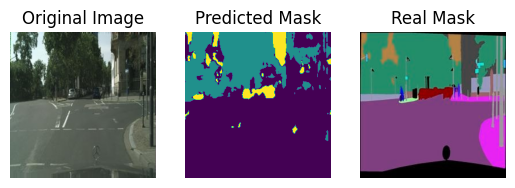

In [51]:
test_image_path = "/content/cityscapes_data/val/109.jpg"
test_image = cv2.imread(test_image_path)
image, mask=split_image_and_mask(test_image)
test_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
test_image = test_image / 255.0  

predictions = unet_model.predict(tf.expand_dims(test_image, axis=0))
predicted_mask = predictions[0]
probabilities = tf.nn.softmax(predicted_mask, axis=-1)
predicted_class = tf.argmax(probabilities, axis=-1)

plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(predicted_class) 
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(mask) 
plt.title("Real Mask")
plt.axis("off")

plt.show()

Saving the model into drive

In [21]:
import shutil

model_folder_path = "/content/model"
destination_folder_path = "/content/drive/MyDrive/unet model"
shutil.copytree(model_folder_path, destination_folder_path)

'/content/drive/MyDrive/unet model'